<a href="https://colab.research.google.com/github/TVLlam/1771020412_CNTT17-01_TRAN_VAN_LAM/blob/master/NHOM2_TTNT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

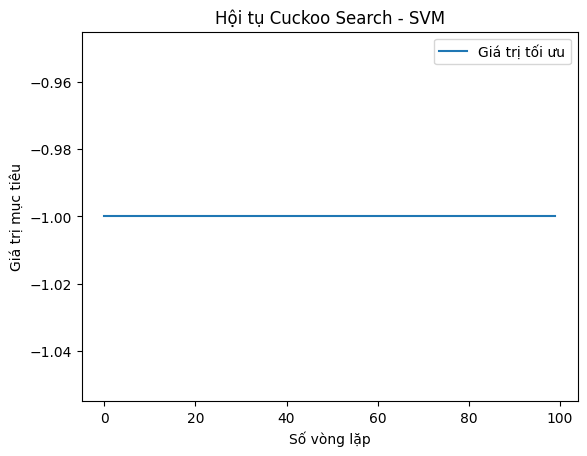

Tham số tối ưu: C=7.3008219019500125, gamma=0.8578780250367358
Độ chính xác tối ưu: 1.0000


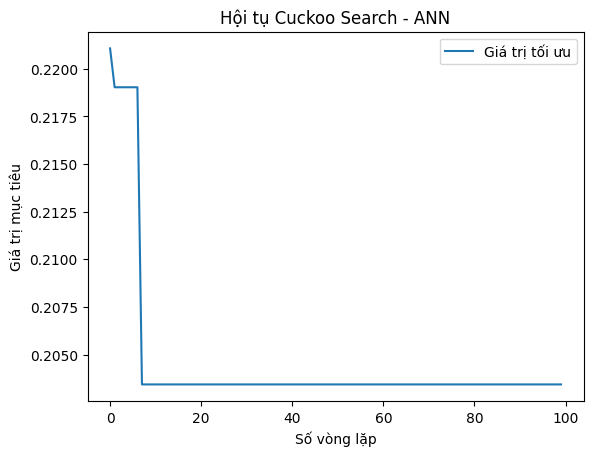

Loss tối ưu: 0.203433


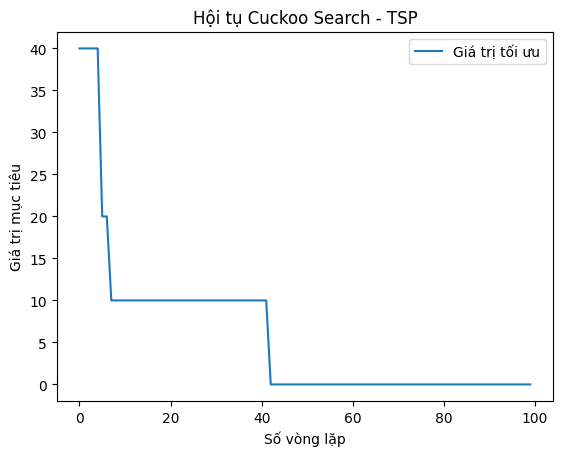

Lộ trình tối ưu: [3, 1, 0, 2, 3]
Tổng quãng đường tối ưu: 0.00


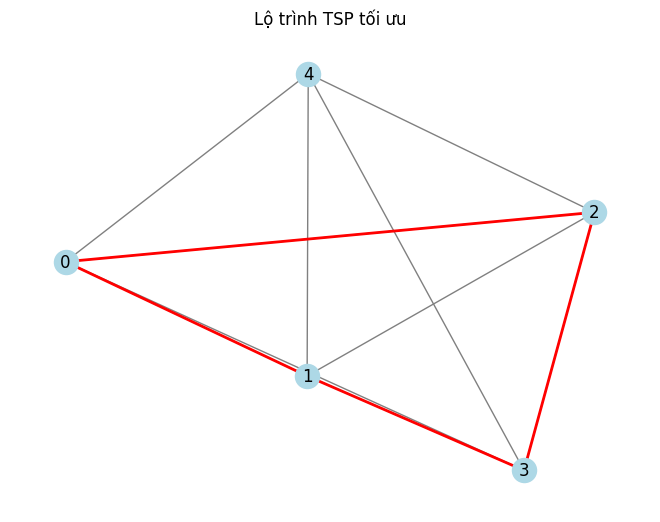

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
import networkx as nx

# Hàm Levy Flight cho thuật toán Cuckoo Search
def levy_flight(Lambda, size):
    sigma = (gamma(1 + Lambda) * np.sin(np.pi * Lambda / 2) /
             (gamma((1 + Lambda) / 2) * Lambda * 2 ** ((Lambda - 1) / 2))) ** (1 / Lambda)
    u = np.random.randn(*size) * sigma
    v = np.random.randn(*size)
    step = u / np.abs(v) ** (1 / Lambda)
    return step

# Lớp thuật toán Cuckoo Search
class ToiUuCuckooSearch:
    def __init__(self, ham_muc_tieu, so_chieu, gioi_han, so_to=15, so_vong_lap=100, xac_suat_pa=0.25, he_so_alpha=0.01):
        self.ham_muc_tieu = ham_muc_tieu
        self.so_chieu = so_chieu
        self.gioi_han = np.array(gioi_han)
        self.so_to = so_to
        self.so_vong_lap = so_vong_lap
        self.xac_suat_pa = xac_suat_pa
        self.he_so_alpha = he_so_alpha
        self.to = np.random.uniform(self.gioi_han[:, 0], self.gioi_han[:, 1], (so_to, so_chieu))
        self.diem_so = np.array([self.ham_muc_tieu(nest) for nest in self.to])
        self.to_tot_nhat = self.to[np.argmin(self.diem_so)]
        self.diem_tot_nhat = np.min(self.diem_so)
        self.history = []

    def toi_uu(self):
        for vong in range(self.so_vong_lap):
            to_moi = self.to + self.he_so_alpha * levy_flight(1.5, self.to.shape)
            to_moi = np.clip(to_moi, self.gioi_han[:, 0], self.gioi_han[:, 1])
            diem_moi = np.array([self.ham_muc_tieu(nest) for nest in to_moi])

            cai_thien = diem_moi < self.diem_so
            self.to[cai_thien] = to_moi[cai_thien]
            self.diem_so[cai_thien] = diem_moi[cai_thien]

            min_idx = np.argmin(self.diem_so)
            if self.diem_so[min_idx] < self.diem_tot_nhat:
                self.to_tot_nhat, self.diem_tot_nhat = self.to[min_idx], self.diem_so[min_idx]

            to_xau = np.random.rand(self.so_to) < self.xac_suat_pa
            self.to[to_xau] = np.random.uniform(self.gioi_han[:, 0], self.gioi_han[:, 1], (np.sum(to_xau), self.so_chieu))
            self.diem_so[to_xau] = np.array([self.ham_muc_tieu(nest) for nest in self.to[to_xau]])

            self.history.append(self.diem_tot_nhat)
        return self.to_tot_nhat, self.diem_tot_nhat

    def plot_convergence(self, title):
        plt.plot(self.history, label='Giá trị tối ưu')
        plt.xlabel('Số vòng lặp')
        plt.ylabel('Giá trị mục tiêu')
        plt.title(title)
        plt.legend()
        plt.show()

# ===========================
# Tối ưu hóa SVM
# ===========================
iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def ham_muc_tieu_svm(tham_so):
    C, gamma = tham_so
    model = SVC(C=C, gamma=gamma, kernel='rbf')
    model.fit(X_train, y_train)
    y_du_doan = model.predict(X_test)
    return -accuracy_score(y_test, y_du_doan)

svm_toi_uu = ToiUuCuckooSearch(ham_muc_tieu_svm, so_chieu=2, gioi_han=[[0.1, 10], [0.0001, 1]])
best_svm_params, best_svm_acc = svm_toi_uu.toi_uu()
svm_toi_uu.plot_convergence('Hội tụ Cuckoo Search - SVM')

print(f'Tham số tối ưu: C={best_svm_params[0]}, gamma={best_svm_params[1]}')
print(f'Độ chính xác tối ưu: {-best_svm_acc:.4f}')

# ===========================
# Tối ưu hóa ANN
# ===========================
y_train_onehot = OneHotEncoder(sparse_output=False).fit_transform(y_train.reshape(-1, 1))

def ham_muc_tieu_ann(trong_so):
    W1 = trong_so[:20].reshape(4, 5)
    b1 = trong_so[20:25]
    W2 = trong_so[25:40].reshape(5, 3)
    b2 = trong_so[40:]
    hidden = 1 / (1 + np.exp(-(np.dot(X_train, W1) + b1)))
    output = 1 / (1 + np.exp(-(np.dot(hidden, W2) + b2)))
    return np.mean((output - y_train_onehot) ** 2)

ann_toi_uu = ToiUuCuckooSearch(ham_muc_tieu_ann, so_chieu=43, gioi_han=[[-1, 1]] * 43)
best_ann_weights, best_ann_loss = ann_toi_uu.toi_uu()
ann_toi_uu.plot_convergence('Hội tụ Cuckoo Search - ANN')

print(f'Loss tối ưu: {best_ann_loss:.6f}')

# ===========================
# Giải bài toán TSP
# ===========================
distance_matrix = np.array([
    [0, 10, 15, 20, 25],
    [10, 0, 35, 25, 30],
    [15, 35, 0, 30, 20],
    [20, 25, 30, 0, 15],
    [25, 30, 20, 15, 0]
])
num_cities = distance_matrix.shape[0]

def ham_muc_tieu_tsp(duong_di):
    return sum(distance_matrix[int(duong_di[i]), int(duong_di[i+1])] for i in range(len(duong_di)-1))

tsp_toi_uu = ToiUuCuckooSearch(ham_muc_tieu_tsp, so_chieu=num_cities, gioi_han=[[0, num_cities-1]] * num_cities)
best_tsp_path, best_tsp_distance = tsp_toi_uu.toi_uu()
tsp_toi_uu.plot_convergence('Hội tụ Cuckoo Search - TSP')

# Chuyển lộ trình sang danh sách các thành phố nguyên (làm tròn giá trị)
best_tsp_path = np.round(best_tsp_path).astype(int)

# In kết quả tối ưu
print(f'Lộ trình tối ưu: {best_tsp_path.tolist()}')
print(f'Tổng quãng đường tối ưu: {best_tsp_distance:.2f}')

# Vẽ đồ thị TSP tối ưu
G = nx.Graph()
for i in range(num_cities):
    for j in range(i+1, num_cities):
        G.add_edge(i, j, weight=distance_matrix[i, j])

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')

# Vẽ lộ trình tối ưu trên đồ thị
edges = [(best_tsp_path[i], best_tsp_path[i+1]) for i in range(len(best_tsp_path)-1)]
nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color='red', width=2)
plt.title('Lộ trình TSP tối ưu')
plt.show()

